# Taller de Redes Neuronales: _Una breve aplicación de entrenamiento de modelos para computación científica_

### Semana IF 2024, impartido por Julián Sánchez Castro

---

## Caso práctico: identificación de casos de COVID empleando tomografías computarizadas (CT scan)



# 1) Cargar las librerías

<p style="font-size: 24px;">
  Para trabajar con redes neuronales, haremos uso del framework <strong>Keras</strong>, que ha sido incorporado a <strong>Tensorflow</strong> debido a su facilidad de experimentación, adaptación y simplicidad.

</p>

<p align="center">
  <img src="https://i.imgur.com/0BkUuMW.jpeg" alt="logos de Tensorflow y Keras" style="width: 40%; height: auto;">
</p>

<p style="font-size: 24px;">
  Principalmente trabajaremos con las utilidades de esta librería, sin embargo también haremos uso de las métricas brindadas por <strong>scikit-learn</strong>, una implementación de las herramientas de Machine Learning en Python. Esta puede trabajar para resolver problemas de clasificación, regresión, clustering y muchos más, por lo que es altamente versatil.
</p>

<p align="center">
  <img src="https://amueller.github.io/sklearn_014_015_pydata/sklearn-logo.png" alt="logo de sklearn" style="width: 40%; height: auto;">
</p>

<p style="font-size: 24px;">
  Finalmente, usaremos librerías estándar como numpy, seaborn, pandas, scipy y matplotlib para el procesamiento, manejo y visualización de los datos.
</p>


In [1]:
# Librerías de preparación
from PIL import Image
import numpy as np
import os

# Librerías del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns
import pandas as pd

# Graficación

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# 2) Procesado de las imágenes

In [3]:
def process_pix(lsf):
    '''Función de procesado de imágenes a una lista de caracteres en escala de grises'''

    arr_normalized = []
    
    for file in lsf:
        # Carga la imagen y la convierte a escala de grises
        img = Image.open(file).convert('L')
        
        # Se escala a 100x100
        img_resized = img.resize((100, 100))
        
        # Se pasa a un array
        img_array = np.array(img_resized)
        
        # Se normalizan para que los valores sean de 0 a 1
        img_normalized = img_array / 255.0
        
        arr_normalized.append(img_normalized)
    
    return np.array(arr_normalized)

## Para el caso de las imágenes con COVID:

In [6]:
directory = "COVID/"

# Enlista las imágenes
lsf = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

# Revisamos el largo (cantidad) de la lista de archivos
print("Cantidad de archivos con COVID:",len(lsf))
 
# Se genera la lista de datos (imágenes convertidos en arrays) de covid
covid = process_pix(lsf)

# En vez de un array lineal, trabajamos con una matriz 100x100

covid_reshaped = covid.reshape(covid.shape[0], 100 * 100)

Cantidad de archivos con COVID: 1252


## Para el caso de las imágenes sin COVID (non-COVID):

In [7]:
directory = "non-COVID/"

lsf = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

print("Cantidad de archivos sin COVID:",len(lsf))

ncovid = process_pix(lsf)
ncovid_reshaped = ncovid.reshape(ncovid.shape[0], 100 * 100)

Cantidad de archivos sin COVID: 1229


## Ahora ploteamos las imágenes

In [8]:
def plot_image(image_array, title):
    plt.imshow(np.flipud(image_array.T), cmap='gray')
    plt.title(title)
    plt.axis('off')

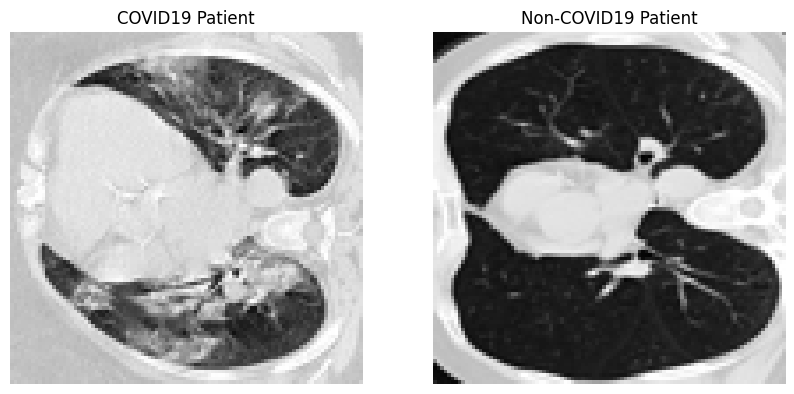

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_image(covid[10, :, :], "COVID19 Patient")

plt.subplot(1, 2, 2)
plot_image(ncovid[10, :, :], "Non-COVID19 Patient")

plt.show()

# 3) Codificación de las imágenes

<p style="font-size: 24px;">
    Es necesario contar con una codificación para el entrenamiento, ya que se trata con un problema de clasificación. Se asignará un <strong>1 para los pacientes con COVID</strong> y un <strong>0 para aquellos sin COVID</strong>.
</p>

<p style="font-size: 24px;">
    Más importante aun, es asegurarse de hacer una aleatorización de los datos, para que el entrenamiento sea firme.
</p>

In [10]:
# Se agregan labels al covid y ncovid, en que un 1 es covid y un 0 para ncovid
covid_labeled = np.hstack((covid_reshaped, np.ones((covid_reshaped.shape[0], 1))))
ncovid_labeled = np.hstack((ncovid_reshaped, np.zeros((ncovid_reshaped.shape[0], 1))))

# Se genera un solo df de forma vertical (covid sobre ncovid)
df = np.vstack((covid_labeled, ncovid_labeled))

# Setea un seed (por consistencia)
np.random.seed(1234)

# Hace un shuffle del array para que se aleatorice
shuffle = np.random.permutation(df.shape[0])
df = df[shuffle]

# 4) Separación de los datos de entrenamiento y testeo

<p style="font-size: 24px;">
  Para construir un modelo, es necesario entrenarlo y luego probarlo. Existen múltiples formas de seleccionar los datos de entrenamiento y testeo:
</p>

<ul style="font-size: 18px;">
  <li><strong>Hold-Out (HO):</strong> porcentajes fijos</li>
  <li><strong>Cross-Validation (CV):</strong> crea múltiples (k) particiones en vez de solo dos como en HO</li>
  <li><strong>Nested-Cross-Validation (NCV):</strong> crea particiones dentro de las particiones</li>
  <li><strong>Leave-One-Out Cross-Validation (LOOCV):</strong> usa tantas particiones como instancias en el dataset</li>  
</ul>

<p style="font-size: 24px;">
  En nuestro caso usaremos HO por la sencillez a nivel computacional y de rendimiento.
</p>


In [12]:
# Setear la seed
np.random.seed(2022)

# Se separa la data en 70% training y 30% test
split = np.random.choice([1, 2], size=df.shape[0], p=[0.7, 0.3])

# Saca los datos de entreno y testeo
train = df[split == 1, :10000]
test = df[split == 2, :10000]

# Saca los labels
train_target = df[split == 1, 10000]
test_target = df[split == 2, 10000]

print("Tamaño del entrenamiento:", train.shape)
print("Tamaño del testeo:", test.shape)

Tamaño del entrenamiento: (1720, 10000)
Tamaño del testeo: (761, 10000)


# 5) Entrenamiento del modelo

<p style="font-size: 24px;">
  Entrenar un modelo se compone de múltiples etapas, que dependerán de la profundidad del dataset, la cantidad de variables involucradas y en general el rendimiento que se desea obtener. La idea principal de una red neuronal es realizar una <strong>regresión a base de múltiples capas de procesamiento</strong>, con una cantidad de neuronas definidas y una función de activación diferente. 
</p>

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*gKFs7YU44vJFiS2rF3-bpg.png" alt="perceptrón" style="width: 60%; height: auto;">
</p>

<p style="font-size: 24px;">
  Sin embargo, en vez de hablar de <em>pendientes</em>, se habla de <em>pesos</em>, donde dependiendo de la suma de los pesos con sus respectivas variables, la neurona se activará o no (de aquí la evidente relación con una regresión lineal).
</p>

<p style="font-size: 24px;">
  Existen múltiples capas que se le pueden agregar al modelo, estas se pueden revisar en la <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">documentación de Keras</a>. Para este ejemplo, usaremos <strong>Dense</strong> (as in deeply connected) y <strong>Dropout</strong> (para evitar memorización en vez de aprendizaje).
</p>

<p align="center">
  <img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/04/Fig-1-3-scaled-1.jpg" alt="Dense layer" style="width: 60%; height: auto;">
</p>

<p align="center">
  <img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/05/2-1-2048x745-1.jpg" alt="Dropout layer" style="width: 60%; height: auto;">
</p>




## Primero se construye el modelo con las capas secuencialmente y se compila

In [14]:
# Se construye el modelo
model = Sequential()

# Se agregan las capas de 80, 40 y 20 unidades de función rectifier (ReLU)
model.add(Dense(80, activation='relu', input_shape=(10000,)))
model.add(Dense(40, activation='relu', input_shape=(10000,)))
model.add(Dense(20, activation='relu', input_shape=(10000,)))
# Se agrega una capa de dropout del 20%
model.add(Dropout(0.20))
# Se agrega una capa de salida coherente con la codificación (1 o 0, 2 unidades), con la función softmax (exponencial normalizada)
model.add(Dense(2, activation='softmax'))
# Se compila el modelo con el optimizador Adam (adaptative learning rates)
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
# Se asignan los labels basándonos en la codificación
train_label = to_categorical(train_target)
test_label = to_categorical(test_target)

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Seguidamente se entrena el modelo

In [16]:
epochs = 50

fit_covid = model.fit(x=train,
                      y=train_label,
                      epochs=epochs,
                      batch_size=16,
                      verbose=1,
                      validation_split=0.2)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7277 - loss: 0.5615 - val_accuracy: 0.7820 - val_loss: 0.5388
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6800 - loss: 0.6010 - val_accuracy: 0.7762 - val_loss: 0.4947
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7155 - loss: 0.5559 - val_accuracy: 0.7994 - val_loss: 0.4892
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7054 - loss: 0.5590 - val_accuracy: 0.8023 - val_loss: 0.4858
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7511 - loss: 0.5510 - val_accuracy: 0.7733 - val_loss: 0.4792
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8001 - loss: 0.4773 - val_accuracy: 0.7733 - val_loss: 0.5228
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7638 - loss: 0.5010 - val_accuracy: 0.8140 - val_loss: 0.4611
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7654 - loss: 0.5071 - val_accuracy: 0.7994 - val_loss

## Entrenado el modelo, se necesita apreciar su exactitud y pérdida

In [17]:
# Graficación del accuracy y loss

def plot_with_spline(x, y, label, color):
    x_smooth = np.linspace(x.min(), x.max(), 500)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, color=color, label=label)

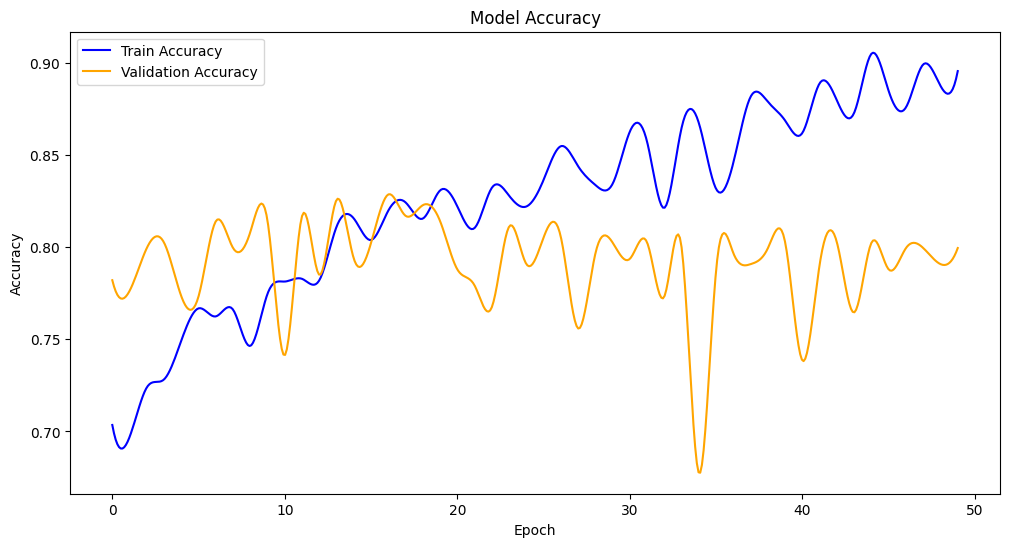

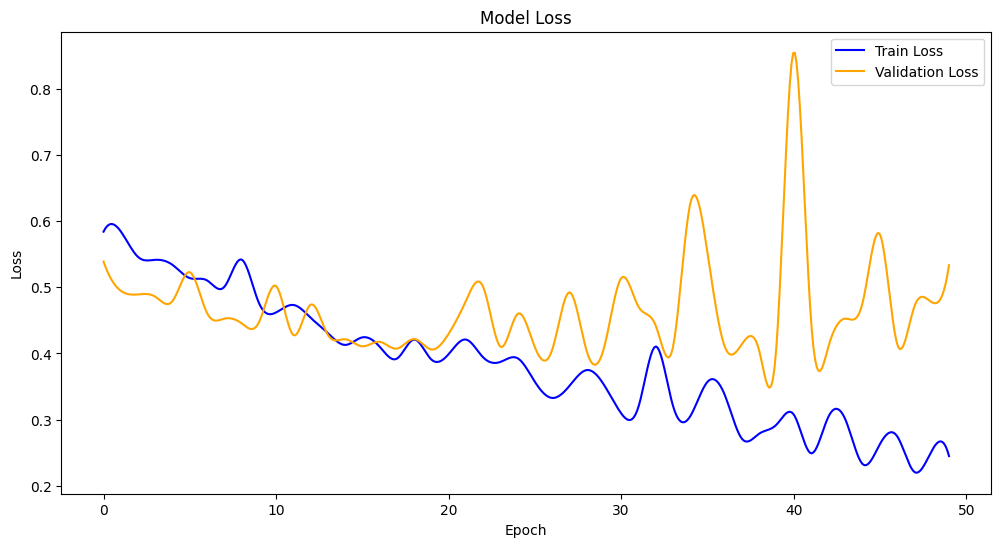

In [19]:
# Gráfico de training & validation accuracy con un spline
plt.figure(figsize=(12, 6))
x_acc = np.arange(len(fit_covid.history['accuracy']))
plot_with_spline(x_acc, fit_covid.history['accuracy'], 'Train Accuracy', 'blue')
plot_with_spline(x_acc, fit_covid.history['val_accuracy'], 'Validation Accuracy', 'orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfico de training & validation loss con un spline
plt.figure(figsize=(12, 6))
x_loss = np.arange(len(fit_covid.history['loss']))
plot_with_spline(x_loss, fit_covid.history['loss'], 'Train Loss', 'blue')
plot_with_spline(x_loss, fit_covid.history['val_loss'], 'Validation Loss', 'orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6) Evaluación del modelo

<p style="font-size: 24px;">
  Para evaluar el modelo, nuestra principal métrica será la <strong>exactitud</strong>. Además, haremos uso de la <strong>matriz de confusión</strong> para entender la distribución de aciertos-fallos del modelo, así como otros parámetros descriptivos.
</p>


In [22]:
# Se evalua el modelo con los datos de testing
test_loss, test_accuracy = model.evaluate(test, test_label, verbose=1)

print(f'Test loss: {test_loss}')
print(f'Exactitud de prueba: {test_accuracy}')

# Se predicen las probabilidades en el test
predictions_prob = model.predict(test)
# Se convierten a labels de predicción
predictions = np.argmax(predictions_prob, axis=1)
# Se pasan a labels
expected_value = np.argmax(test_label, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 0.5986
Test loss: 0.5524700880050659
Exactitud de prueba: 0.802890956401825
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Se visualiza la matriz de confusión

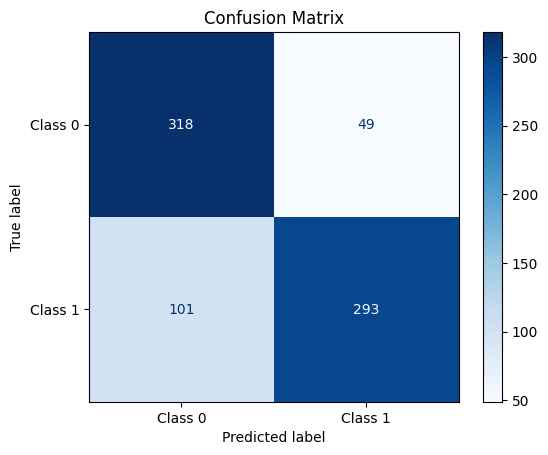

In [26]:
# Se categorizan las predicciones y valores esperados
predictions = np.array(predictions)
expected_value = np.array(expected_value)

# Se computa la matriz de confusión
cm = confusion_matrix(expected_value, predictions)
cm_df = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Se calculan los estadísticos
accuracy = accuracy_score(expected_value, predictions)
precision = precision_score(expected_value, predictions, average='binary')
recall = recall_score(expected_value, predictions, average='binary')
f1 = f1_score(expected_value, predictions, average='binary')
kappa = cohen_kappa_score(expected_value, predictions)

# Cálculo de las métricas
sensitivity = recall
specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else np.nan
positive_pred_value = precision
negative_pred_value = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else np.nan
prevalence = (cm[0, 0] + cm[0, 1]) / np.sum(cm)
detection_rate = sensitivity
detection_prevalence = cm[1, 1] / np.sum(cm)
balanced_accuracy = (sensitivity + specificity) / 2

print("Matriz de Confusión:\n")
print(cm_df)
print("\n")
print(f"Exactitud : {accuracy:.4f}")
print(f"Tasa de Información Nula : {accuracy:.4f}")
print(f"Kappa : {kappa:.4f}")
print(f"Sensibilidad : {sensitivity:.4f}")
print(f"Especificidad : {specificity:.4f}")
print(f"Valor Predicho Positivo : {positive_pred_value:.4f}")
print(f"Valor Predicho Negativo : {negative_pred_value:.4f}")
print(f"Prevalencia : {prevalence:.4f}")
print(f"Tasa de Detección : {detection_rate:.4f}")
print(f"Prevalencia de Detección : {detection_prevalence:.4f}")
print(f"Exactitud Balanceada : {balanced_accuracy:.4f}")
print("\nClase 'Positiva' : 1")

Matriz de Confusión:

     0    1
0  318   49
1  101  293


Exactitud : 0.8029
Tasa de Información Nula : 0.8029
Kappa : 0.6072
Sensibilidad : 0.7437
Especificidad : 0.7437
Valor Predicho Positivo : 0.8567
Valor Predicho Negativo : 0.8665
Prevalencia : 0.4823
Tasa de Detección : 0.7437
Prevalencia de Detección : 0.3850
Exactitud Balanceada : 0.7437

Clase 'Positiva' : 1


# 7) Ejecución de un bucle de repeticiones/testeo*

### *Opcional

<p style="font-size: 24px;">
  En caso de querer hacer pruebas de repetibilidad, se provee un bloque conciso que corre modificando el modelo, por lo que igualmente necesita de la existencia de los datos y los pasos previos.
</p>

In [33]:
accuracy_lista = []

for i in range(5):
    model = Sequential()
    model.add(Dense(80, activation='relu', input_shape=(10000,)))
    model.add(Dense(40, activation='relu', input_shape=(10000,)))
    model.add(Dense(20, activation='relu', input_shape=(10000,)))
    model.add(Dropout(0.20))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    train_label = to_categorical(train_target)
    test_label = to_categorical(test_target)
    fit_covid = model.fit(x=train,
                      y=train_label,
                      epochs=10,
                      batch_size=16,
                      verbose=1,
                      validation_split=0.2)
    test_loss, test_accuracy = model.evaluate(test, test_label, verbose=1)

    predictions_prob = model.predict(test)

    predictions = np.argmax(predictions_prob, axis=1)
    expected_value = np.argmax(test_label, axis=1)

    predictions = np.array(predictions)
    expected_value = np.array(expected_value)

    cm = confusion_matrix(expected_value, predictions)

    predictions = np.array(predictions)
    expected_value = np.array(expected_value)


    cm = confusion_matrix(expected_value, predictions)
    cm_df = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])


    accuracy = accuracy_score(expected_value, predictions)
    accuracy_lista.append(accuracy)

print("The mean accuracy is", np.mean(accuracy_lista))

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5189 - loss: 0.8232 - val_accuracy: 0.6890 - val_loss: 0.6569
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6292 - loss: 0.6597 - val_accuracy: 0.7064 - val_loss: 0.6085
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6848 - loss: 0.6107 - val_accuracy: 0.7442 - val_loss: 0.5428
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6930 - loss: 0.6035 - val_accuracy: 0.7587 - val_loss: 0.5348
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7279 - loss: 0.5564 - val_accuracy: 0.7733 - val_loss: 0.5016
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7189 - loss: 0.5614 - val_accuracy: 0.7180 - val_loss: 0.5320
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7169 - loss: 0.5452 - val_accuracy: 0.7849 - val_loss: 0.4823
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7347 - loss: 0.5216 - val_accuracy: 0.7733 - val_los

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5377 - loss: 0.9321 - val_accuracy: 0.7006 - val_loss: 0.6351
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6160 - loss: 0.6398 - val_accuracy: 0.5959 - val_loss: 0.6294
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6623 - loss: 0.6071 - val_accuracy: 0.5988 - val_loss: 0.6700
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6829 - loss: 0.5931 - val_accuracy: 0.6977 - val_loss: 0.5596
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7027 - loss: 0.5726 - val_accuracy: 0.7297 - val_loss: 0.5256
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7272 - loss: 0.5801 - val_accuracy: 0.7849 - val_loss: 0.4985
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7172 - loss: 0.5644 - val_accuracy: 0.7791 - val_loss: 0.6147
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6707 - loss: 0.6273 - val_accuracy: 0.7674 - val_loss: 0.5555
Ep

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5571 - loss: 0.7772 - val_accuracy: 0.6483 - val_loss: 0.6140
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6606 - loss: 0.6186 - val_accuracy: 0.7326 - val_loss: 0.5802
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5898 - loss: 0.6717 - val_accuracy: 0.7733 - val_loss: 0.5218
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6748 - loss: 0.5970 - val_accuracy: 0.7762 - val_loss: 0.5003
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6390 - loss: 0.6161 - val_accuracy: 0.6744 - val_loss: 0.6466
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6716 - loss: 0.6222 - val_accuracy: 0.7820 - val_loss: 0.5135
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7470 - loss: 0.5421 - val_accuracy: 0.7907 - val_loss: 0.4983
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7354 - loss: 0.5244 - val_accuracy: 0.7500 - val_loss: 0.5262
Ep

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5233 - loss: 0.8292 - val_accuracy: 0.6890 - val_loss: 0.6825
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5220 - loss: 0.6925 - val_accuracy: 0.4826 - val_loss: 0.6935
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accuracy: 0.4826 - val_loss: 0.6935
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4956 - loss: 0.6933 - val_accuracy: 0.4826 - val_loss: 0.6934
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6934
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4869 - loss: 0.6934 - val_accuracy: 0.4826 - val_loss: 0.6934
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4789 - loss: 0.6935 - val_accuracy: 0.4826 - val_loss: 0.6934
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6934
Ep

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4861 - loss: 0.7520 - val_accuracy: 0.4826 - val_loss: 0.6932
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4867 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6932
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4884 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6933
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4948 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6933
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5089 - loss: 0.6931 - val_accuracy: 0.4826 - val_loss: 0.6933
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5029 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6933
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4830 - loss: 0.6933 - val_accuracy: 0.4826 - val_loss: 0.6934
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4964 - loss: 0.6932 - val_accuracy: 0.4826 - val_loss: 0.6933
Ep